## Topic Modeling with LDA

In this section we develop a topic model using Latent Dirichlet Allocation (LDA) to discover unobserved themes across papers. This may have practical value in the following ways: 

1. Uncovering nontrivial relationships between disparate fields of research 
2. Organizing papers into useful categories
3. Navigating citations based on their usage in papers within & across categories

#### Step 1: Import & Preprocess Data

In [404]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.manifold import TSNE
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from datasets import load_dataset
from natsort import natsort_keygen

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mattroth/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [405]:
# Load pubmed dataset from huggingface
articles = load_dataset("scientific_papers", "pubmed", split="train")
df_articles = pd.DataFrame(articles)

Found cached dataset scientific_papers (/Users/mattroth/.cache/huggingface/datasets/scientific_papers/pubmed/1.1.1/306757013fb6f37089b6a75469e6638a553bd9f009484938d8f75a4c5e84206f)


In [406]:
# Inspect df_articles
df_articles.head()

,article,abstract,section_names
0,a recent systematic analysis showed that in 20...,background : the present study was carried ou...,INTRODUCTION\nMATERIALS AND METHODS\nParticipa...
1,it occurs in more than 50% of patients and may...,backgroundanemia in patients with cancer who ...,Introduction\nPatients and methods\nStudy desi...
2,"tardive dystonia ( td ) , a rarer side effect ...",tardive dystonia ( td ) is a serious side eff...,INTRODUCTION\nCASE REPORT\nDISCUSSION\nDeclara...
3,"lepidoptera include agricultural pests that , ...",many lepidopteran insects are agricultural pe...,1. Introduction\n2. Insect Immunity\n3. Signal...
4,syncope is caused by transient diffuse cerebra...,we present an unusual case of recurrent cough...,Introduction\nCase report\nDiscussion\nConflic...


In [407]:
# Lemmatize article text
lem = WordNetLemmatizer()
def lemmatize_text(text):
    return [lem.lemmatize(w) for w in tokenizer.tokenize(text)]

df_articles['article_lemmatized'] = df_articles["article"].apply(lambda x: lemmatize_text(x))
df_articles["article_lemmatized"] = df_articles["article_lemmatized"].apply(lambda x: " ".join(x))

# Initialize regex tokenizer
tokenizer = RegexpTokenizer(
    "(?:(?<=\s)|(?<=^)|(?<=[>\"]))[a-z-']+(?:(?=\s)|(?=\:\s)|(?=$)|(?=[.!,;\"]))"
)

# Create custom stop words set with units and others
custom_stop_words = text.ENGLISH_STOP_WORDS.union([
    "et","al", # from et al
    "mg","g","kg","lb", # mass / weight
    "ml","l","dl","oz", # volume
    "nm","mm","cm","m","ft", # length
    "c","f" # temperature
    ])

# Encode data with TF-IDF
tfidf = TfidfVectorizer(lowercase=True,
                        stop_words=list(custom_stop_words),
                        max_df=0.90, # ignore words occuring in more than this % of docs
                        min_df=0.02, # ignore words occuring in less than this % of docs
                        max_features=1000,
                        tokenizer=tokenizer.tokenize)
vectorized_articles = tfidf.fit_transform(df_articles["article_lemmatized"])

# Save vocab
vocab = tfidf.get_feature_names_out()

/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


#### Step 2: Run LDA

In [422]:
# Instantiate LDA
n_topics = 20
lda = LDA(n_components=n_topics, n_jobs=-1)

# Run on vectorized_articles
X_topics = lda.fit_transform(vectorized_articles)

In [423]:
# Get topic distribution
topic_words = lda.components_

# Retrieve topics
topics_top3_words = {}
for i, topic_dist in enumerate(topic_words):
    
    # Zip vocab and topic distribution
    zipped_3 = zip(vocab, topic_dist)
    zipped_10 = zip(vocab, topic_dist)

    # # Sort and get out top 3 words for each topic for dict
    top_terms_key_3 = sorted(zipped_3, key=lambda t: t[1], reverse=True)[0:3]
    top_terms_list_3 = list(dict(top_terms_key_3).keys())

    # Do again with top 10 words to print here
    top_terms_key_10 = sorted(zipped_10, key=lambda t: t[1], reverse=True)[0:10]
    top_terms_list_10 = list(dict(top_terms_key_10).keys())

    topic_results = f"Topic {i + 1}: {top_terms_list_10}"
    print(topic_results)

    topics_top3_words[i] = f"Topic {i + 1}: {top_terms_list_3}"
    

Topic 1: ['infection', 'virus', 'patient', 'hiv', 'isolates', 'infected', 'sample', 'positive', 'study', 'pcr']
Topic 2: ['teeth', 'tooth', 'dental', 'root', 'canal', 'surface', 'group', 'material', 'study', 'oral']
Topic 3: ['fracture', 'bone', 'muscle', 'patient', 'implant', 'knee', 'joint', 'pain', 'study', 'exercise']
Topic 4: ['gene', 'sequence', 'mutation', 'genome', 'dna', 'allele', 'genotype', 'pcr', 'protein', 'genetic']
Topic 5: ['diabetes', 'insulin', 'study', 'patient', 'glucose', 'bmi', 'risk', 'obesity', 'group', 'diabetic']
Topic 6: ['lesion', 'patient', 'case', 'cyst', 'tumor', 'right', 'diagnosis', 'left', 'mass', 'ct']
Topic 7: ['cell', 'protein', 'h', 'concentration', 'medium', 'min', 'figure', 'peptide', 'using', 'compound']
Topic 8: ['tumor', 'cancer', 'patient', 'cell', 'metastasis', 'carcinoma', 'breast', 'case', 'lesion', 'node']
Topic 9: ['health', 'patient', 'care', 'study', 'student', 'service', 'participant', 'score', 'research', 'medical']
Topic 10: ['figur

In [424]:
# Assign topics to articles
article_topics = lda.transform(vectorized_articles)

topics = []
for i in range(article_topics.shape[0]):

    # Get most likely topic for each article
    topic = article_topics[i].argmax() + 1
    topics.append(topic)

# Add columns to df_articles
df_articles["main_topic"] = topics
for i in range(article_topics.shape[1]):
    df_articles[f"Topic{i+1}"] = article_topics[:,i]

In [425]:
# Inspect df_articles with topic
df_articles.head()

,article,abstract,section_names,article_lemmatized,main_topic,topic1_prob,topic2_prob,topic3_prob,topic4_prob,topic5_prob,...,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20
0,a recent systematic analysis showed that in 20...,background : the present study was carried ou...,INTRODUCTION\nMATERIALS AND METHODS\nParticipa...,a recent systematic analysis showed that in - ...,9,0.010616,0.904450,0.010619,0.010616,0.010617,...,0.005307,0.005307,0.005307,0.005307,0.005307,0.005307,0.005307,0.005307,0.005307,0.005307
1,it occurs in more than 50% of patients and may...,backgroundanemia in patients with cancer who ...,Introduction\nPatients and methods\nStudy desi...,it occurs in more than of patient and may reac...,18,0.009744,0.009743,0.009743,0.009747,0.009743,...,0.004870,0.004870,0.004870,0.004870,0.004870,0.004870,0.004870,0.907462,0.004870,0.004870
2,"tardive dystonia ( td ) , a rarer side effect ...",tardive dystonia ( td ) is a serious side eff...,INTRODUCTION\nCASE REPORT\nDISCUSSION\nDeclara...,tardive dystonia td a rarer side effect after ...,20,0.602204,0.318759,0.009879,0.009880,0.009879,...,0.004938,0.004938,0.004938,0.004938,0.004938,0.004938,0.004938,0.004938,0.004938,0.906170
3,"lepidoptera include agricultural pests that , ...",many lepidopteran insects are agricultural pe...,1. Introduction\n2. Insect Immunity\n3. Signal...,lepidoptera include agricultural pest that thr...,12,0.010138,0.010138,0.010139,0.010138,0.010138,...,0.005068,0.903711,0.005068,0.005068,0.005068,0.005068,0.005068,0.005068,0.005068,0.005068
4,syncope is caused by transient diffuse cerebra...,we present an unusual case of recurrent cough...,Introduction\nCase report\nDiscussion\nConflic...,syncope is caused by transient diffuse cerebra...,6,0.912059,0.009771,0.009770,0.009775,0.009771,...,0.287897,0.004884,0.004884,0.004884,0.004884,0.004884,0.004884,0.004884,0.004884,0.004884


#### Step 3: Latent Topic Analysis

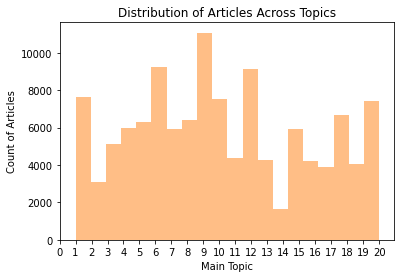

In [426]:
# View distribution of articles over topics
plt.hist(df_articles["main_topic"], bins=n_topics, color="tab:orange", alpha=0.5)
plt.xticks(np.arange(0, n_topics+1, 1.0))
plt.xlabel("Main Topic")
plt.ylabel("Count of Articles")
plt.title("Distribution of Articles Across Topics")
plt.show()

/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


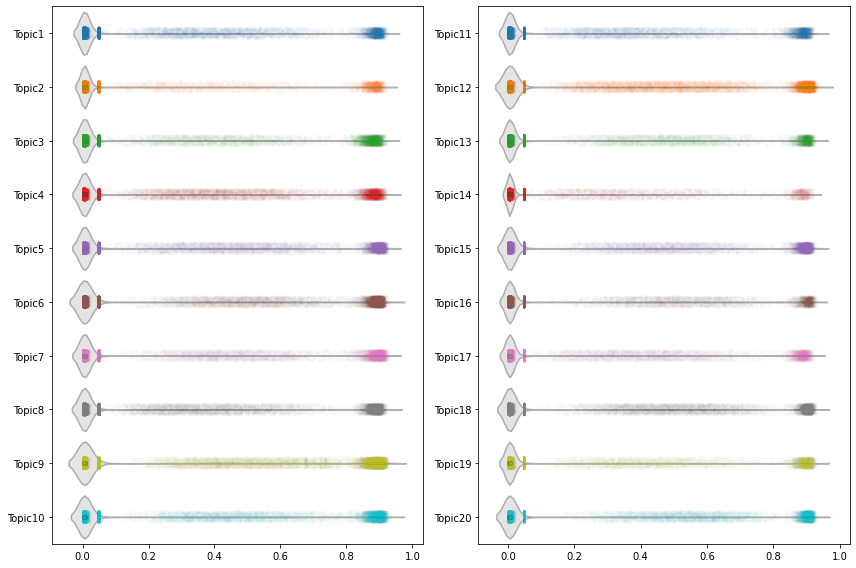

In [437]:
# Violinplot to show distribution of probabilties
topic_probs = df_articles.loc[:, "Topic1":]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
for i in range(2):
    if i == 0:
        sns.violinplot(data=topic_probs.iloc[:,0:int(n_topics/2)], color="lightgray", scale="width", orient='h', ax=axs[i])
        plt.setp(axs[i].collections, alpha=.6)
        sns.stripplot(data=topic_probs.iloc[:,0:int(n_topics/2)], alpha=0.01, size=3, orient='h', ax=axs[i])
    else:
        sns.violinplot(data=topic_probs.iloc[:, int(n_topics/2):], color="lightgray", scale="width", orient='h', ax=axs[i])
        plt.setp(axs[i].collections, alpha=.6)
        sns.stripplot(data=topic_probs.iloc[:, int(n_topics/2):], alpha=0.01, size=3, orient='h', ax=axs[i])
plt.tight_layout()
plt.show()

/var/folders/hf/1k3w_wb93bd1yp7b5_jh65mw0000gn/T/ipykernel_55010/814824867.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(topic_correlations, dtype=np.bool))


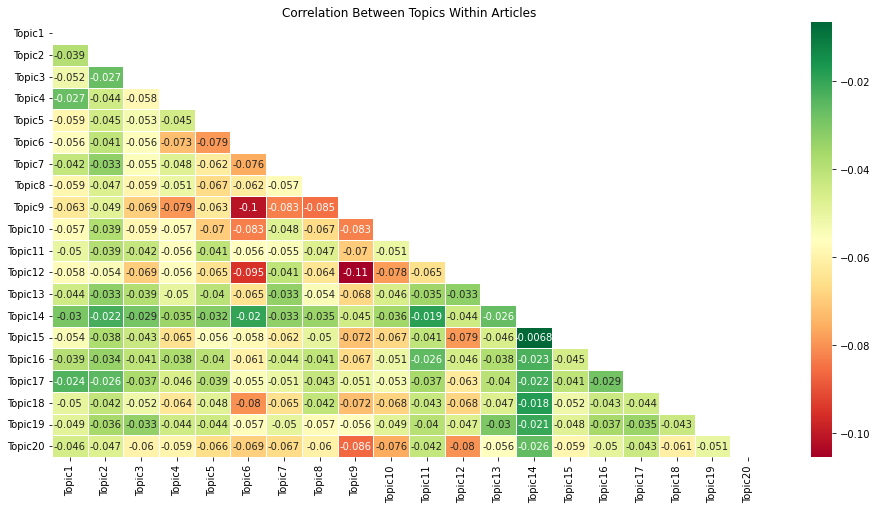

In [441]:
# Visualize correltion between topics
topic_correlations = df_articles.loc[:, "Topic1":].corr()
fig, ax = plt.subplots(figsize=(16,8))
mask = np.triu(np.ones_like(topic_correlations, dtype=np.bool))
sns.heatmap(
    topic_correlations,
    annot=True,
    mask=mask,
    # vmin=-1,
    # vmax=1,
    cmap="RdYlGn",
    linewidth=1
    )
plt.title("Correlation Between Topics Within Articles")
plt.show()

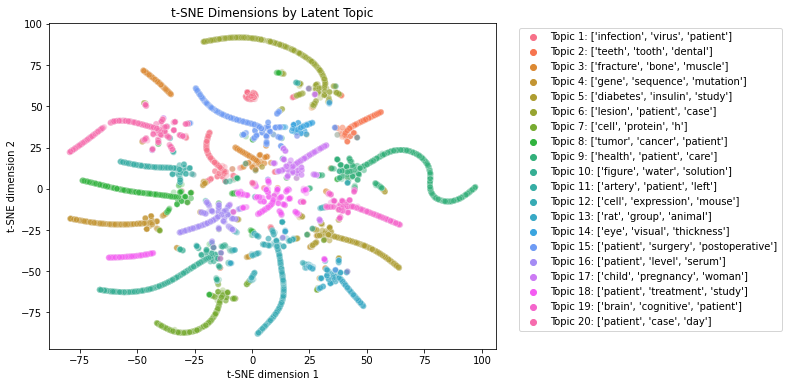

In [429]:
# Visualize topic distributions with t-SNE
tsne = TSNE(perplexity=50)
article_topics_sample = article_topics[np.random.choice(article_topics.shape[0], 
                                         article_topics.shape[0] // 10, 
                                         replace=False)]
tsne_results = tsne.fit_transform(article_topics_sample)
embedding = pd.DataFrame(tsne_results, columns=['x','y'])
embedding["main_topic"] = [topics_top3_words[t] for t in article_topics_sample.argmax(axis=1)]
embedding.sort_values("main_topic", ascending=True, key=natsort_keygen(), inplace=True)

fig, ax = plt.subplots(figsize=(8,6))
sns.scatterplot(
    data=embedding,
    x="x", 
    y="y",
    hue="main_topic",
    palette=sns.color_palette("husl", embedding["main_topic"].nunique()),    
    legend="full",
    alpha=0.3
)
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.title("t-SNE Dimensions by Latent Topic")
ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.show()
